In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.getcwd()

'/content'

In [3]:
!pwd

/content


In [4]:
!ls

drive  sample_data


In [5]:
%cd "/content/drive/MyDrive/Colab Notebooks/voice_emotion_recognition/src/model_architectures"

/content/drive/MyDrive/Colab Notebooks/voice_emotion_recognition/src/model_architectures


In [6]:
!pwd

/content/drive/MyDrive/Colab Notebooks/voice_emotion_recognition/src/model_architectures


In [7]:
!ls

best_modelv5.keras  model.py	    model_v2.py     model_v5.ipynb
model.ipynb	    model_v2.ipynb  model_v4.ipynb  model_v6.ipynb


In [8]:
# ==============================================
# 🎧 model_v6.ipynb: CNN + 2xBiGRU + Class Weights + LR Scheduler
# ==============================================

# ✅ 1. Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D, Dropout, Bidirectional, GRU, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import itertools


In [10]:

# ✅ 2. Load Preprocessed Features
X = np.load("../../data/features/features_v5.npy") #data\features\features_v5.npy
y = np.load("../../data/features/labels_v5.npy",allow_pickle=True)


print("X shape:", X.shape)  # (2880, 128, 173, 1)
print("y shape:", y.shape)  # (2880,)

X = X.squeeze().transpose(0, 2, 1)  # Final shape: (2880, 173, 128)
print("X shape:", X.shape)
print("y shape:", y.shape)  # (2880,)


X shape: (2880, 128, 173, 1)
y shape: (2880,)
X shape: (2880, 173, 128)
y shape: (2880,)


In [11]:

# ✅ 3. Preprocess Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=8)


In [12]:

# ✅ 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y_encoded, random_state=42)


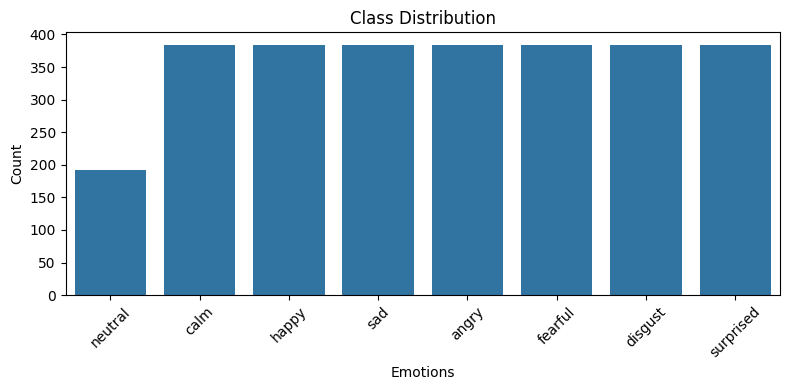

In [13]:

# ✅ 5. Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights))

# ✅ 6. Visualize Class Distribution
plt.figure(figsize=(8,4))
sns.countplot(x=le.inverse_transform(y_encoded))
plt.title("Class Distribution")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:

# ✅ 7. Build model_v6
model = Sequential([
    Input(shape=(173, 128)),

    Conv1D(64, 5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(32, return_sequences=False)),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 173, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 173, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 86, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 86, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 86, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 43, 128)        │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,160 (754.53 KB)

 Trainable params: 192,776 (753.03 KB)

 Non-trainable params: 384 (1.50 KB)

In [15]:

# ✅ 8. Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model_v6.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]


In [16]:

# ✅ 9. Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.1409 - loss: 2.1621 - val_accuracy: 0.1545 - val_loss: 2.0876 - learning_rate: 0.0010
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.1795 - loss: 2.0430 - val_accuracy: 0.2465 - val_loss: 1.9569 - learning_rate: 0.0010
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2124 - loss: 1.9466 - val_accuracy: 0.2049 - val_loss: 1.9263 - learning_rate: 0.0010
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2514 - loss: 1.9228 - val_accuracy: 0.2413 - val_loss: 1.9257 - learning_rate: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.2499 - loss: 1.8570 - val_accuracy: 0.2101 - val_loss: 2.2605 - learning_rate: 0.0010
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3074 - loss: 1.8417 - val_accuracy: 0.2309 - val_loss: 2.0847 - learning_rate: 0.0010
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3087 - loss: 1

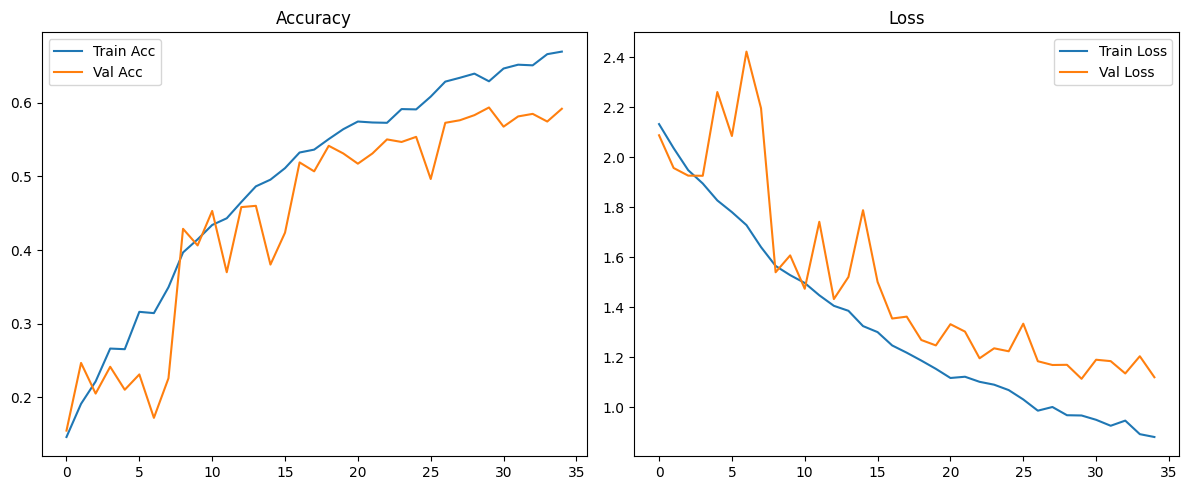

In [17]:

# ✅ 10. Plot Training Curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:

# ✅ 11. Evaluation
model.load_weights("best_model_v6.keras")
y_pred = model.predict(X_test)
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification Report:

              precision    recall  f1-score   support

       angry       0.65      0.76      0.70        76
        calm       0.63      0.77      0.69        77
     disgust       0.76      0.73      0.74        77
     fearful       0.58      0.58      0.58        77
       happy       0.57      0.30      0.39        77
     neutral       0.35      0.87      0.50        38
         sad       0.41      0.21      0.28        77
   surprised       0.73      0.68      0.70        77

    accuracy                           0.59       576
   macro avg       0.59      0.61      0.57       576
weighted avg       0.60      0.59      0.58       576



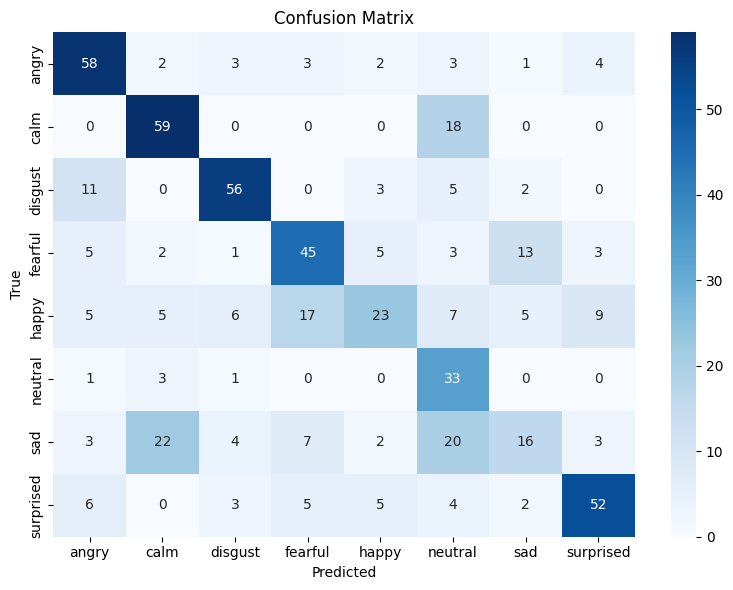

In [19]:

# ✅ 12. Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:

# ✅ 13. Save Final Model
model.save("model_v6.keras")


